https://colab.research.google.com/drive/1qFmP0Nc2SkQphf8UM3KGtVSG4c3hg2Vp?usp=sharing

# import

In [59]:
import re
import os
import csv
import glob
import base64
import requests
import numpy as np 
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [9]:
%%capture
!pip install --upgrade --no-cache-dir gdown
! pip install tqdm

# download and prepare data


In [10]:
# OASIS subjects
%%capture
!gdown 1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV -O data.rar
!mkdir subjects
!unrar x "/content/data.rar" "/content/subjects/"
!rm -r "data.rar"
!mkdir dataset_contain_description
!mkdir dataset_without_description

# preprocess function

## feature extraction

In [11]:
def get_html(url):
    page = requests.get(url).content
    soup = BeautifulSoup(page, "html.parser")
    return soup

def get_html_from_csv(file_path):
    '''
    Thos function get path of file as input and return 
    coressponding html for it.
    Input : path to csv file
    Output : parse html of all pages in csv
    '''
    site_name = (file_path.split('_')[0]).split('/')[-1]
    html_doc = pd.read_csv(file_path, encoding='utf8', on_bad_lines='skip')

    pages = []
    for i, page_html in tqdm(html_doc.iterrows(), total=html_doc.shape[0]):
        html_content = base64.b64decode(page_html['html'])
        pages.append(BeautifulSoup(html_content, "html.parser"))
    return pages

def get_title(soup):
    return soup.find('meta', {'property': 'og:title'})["content"]

def title_content_intersection_ratio(title, content):
    title = np.array(title.split())
    content = np.array(content.split())
    intersection = np.intersect1d(title , content)
    try:
        return len(intersection)/len(content)
    except:
        return 0

## crawl each page html

In [12]:
def create_page_feature(page):

    content_list = []
    title_content_intersection_ratio_list = []
    content_depth_list = []
    content_words_number_list = []
    labels = []

    soup = page

    title = get_title(soup)
    description = soup.find('meta', {'property': 'og:description'})["content"]

    def traverse(t, current_path=None):
        if current_path is None:
            current_path = [t.name]

        for tag in t.find_all(recursive=False):
            if not tag.find():        
                    path = current_path + [tag.name, tag.find(string=True)]
                    content = tag.find(string=True)
                    if str(content) != 'None':
                          content = tag.find(string=True).strip()

                          if str(content) == description:
                            labels.append(1)
                          elif str(content) == title:
                            labels.append(2)
                          else:
                            labels.append(0)
                          
                          content_list.append(str(content))
                          content_depth_list.append(float(len(path)))
                          content_words_number_list.append(len(str(content).split()))
                          title_content_intersection_ratio_list.append(title_content_intersection_ratio(title, str(content)))
                  
            else:
                traverse(tag, current_path + [tag.name])
            

    traverse(soup.body)


    # z score normalize number of words
    content_words_number_list = zscore(content_words_number_list)
    
    data_dict = {'content': content_list,
                 'content lengh' : [len(c.split()) for c in content_list],
                 'depth': content_depth_list,
                 'title_content_intersection_ratio' : title_content_intersection_ratio_list ,
                 'words in content': content_words_number_list, 
                 'label': labels}  


    df_output = pd.DataFrame(data_dict)

    # drop rows when len(content) <= 3
    df_output = df_output[df_output['content lengh']>3]
    df_output = df_output[df_output["title_content_intersection_ratio"] > 0]

    return df_output

## prepare training data

In [13]:
def prepare_training_data(webpage_path_list=['/content/subjects/tasnimnews_all.csv']):
    feature_store = pd.DataFrame(columns=['content',
                                            'content lengh',
                                            'depth',
                                            'title_content_intersection_ratio',
                                            'words in content',
                                            'label']) 
 
    for webpage_path in webpage_path_list:
        feature_store_webpage = pd.DataFrame(columns=['content',
                                                'content lengh',
                                                'depth',
                                                'title_content_intersection_ratio',
                                                'words in content',
                                                'label']) 
        print(webpage_path)
        pages = get_html_from_csv(webpage_path)
        
        print("create feature")
        for page in tqdm(pages):
            try:
                feature_store_webpage = feature_store_webpage.append(create_page_feature(page)) 
            except:
                continue
            
            #normal for each website
            feature_store_webpage['depth_normalize'] = zscore(feature_store_webpage['depth'])
        
        feature_store = feature_store.append(feature_store_webpage)

    feature_store.reset_index(drop=True, inplace=True)

    return feature_store

# Trin model

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## train_test_split

In [34]:
def train_test_split_(dataset):
    dataset[dataset["label"] == 2]["label"] = 0
    dataset['content lengh'] = dataset['content lengh'].astype(int)
    dataset['depth'] = dataset['depth'].astype(int)
    dataset['title_content_intersection_ratio'] = dataset['title_content_intersection_ratio'].astype(float)
    dataset['depth_normalize'] = dataset['depth_normalize'].astype(float)
    dataset['words in content'] = dataset['words in content'].astype(float)
    dataset['label'] = dataset['label'].astype(bool)
    X = dataset.drop(['label', 'content'],axis=1)
    y = dataset['label']
    print("labels : ", y.value_counts())
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)
    return x_train, x_test, y_train, y_test

## Evaluation Metric

In [16]:
def confusion_matrix_(test_labels, predicted_labels, version):
    if not os.path.exists('result'):
        os.makedirs('result')

    print("\nconfusion_matrix\n")
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.subplots(figsize=(10, 6))
    sn.heatmap(cm, annot = True, fmt = 'd', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(f'confusion_matrix_{version}.png', bbox_inches='tight')

def model_result(y_test,y_pred, version):
    ra_score = roc_auc_score(y_test,y_pred)
    a_score = accuracy_score(y_test,y_pred)
    p_score = precision_score(y_test,y_pred)
    r_score = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    
    print('roc_auc_score : ',ra_score)
    print('accuracy_score: ',a_score)
    print('precision_score: ',p_score)
    print('recall_score: ',r_score)
    print('f1-score :', f1)
    print('confusion_matrix: ',confusion_matrix(y_test,y_pred))
    confusion_matrix_(y_test,y_pred, version)

## ML Classifier

In [17]:
%%capture
!pip install catboost

In [55]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

def extra_tree_train(x_train, x_test, y_train, y_test):
    clf = ExtraTreesClassifier(n_estimators=10, criterion='entropy', random_state=0)
    #Train the model using the training sets
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test.fillna(0))
    model_result(y_test,y_pred, version='ExtraTreesClassifier_entropy')



def random_forest_classifier(x_train, x_test, y_train, y_test):
    random_forest_clf = RandomForestClassifier(max_depth=20)
    #Train the model using the training sets
    random_forest_clf.fit(x_train, y_train)
    y_pred = random_forest_clf.predict(x_test.fillna(0))
    model_result(y_test,y_pred, version='RandomForestClassifier')



def catboost_classifier(x_train, x_test, y_train, y_test):
    # initializing the model
    cbc = CatBoostClassifier(iterations=100, max_depth=16)

    # training the model
    cbc.fit(x_train, y_train)
    y_pred = cbc.predict(x_test)
    model_result(y_test,y_pred, version='CatBoostClassifier')


def xgboost_classifier(x_train, x_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier()
    xgb_cl.fit(x_train, y_train)
    y_pred = xgb_cl.predict(x_test)
    model_result(y_test,y_pred, version='XGBClassifier')
    print(xgb_cl.feature_importances_)
    return xgb_cl

def SVM_classifier(x_train, x_test, y_train, y_test):
    # define outlier detection model
    svm_model = SVC()
    svm_model.fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)
    model_result(y_test,y_pred, version='SVMClassifier')

# Main

In [19]:
%%time
warnings.filterwarnings("ignore")
dataset = prepare_training_data(['/content/subjects/ana_press_all.csv'])

/content/subjects/ana_press_all.csv


100%|██████████| 1959/1959 [02:25<00:00, 13.45it/s]


create feature


100%|██████████| 1959/1959 [01:21<00:00, 24.05it/s]

CPU times: user 3min 33s, sys: 3.99 s, total: 3min 37s
Wall time: 3min 53s


In [20]:
dataset

,content,content lengh,depth,title_content_intersection_ratio,words in content,label,depth_normalize
0,هرکه زورش بیش حقش بیشتر!,5,11.0,1.000000,-0.031898,2,-0.605162
1,- اگرچه پیشرفت فیزیکی 97 درصدی داشته است- و هم...,450,10.0,0.002222,18.174941,0,-1.109264
2,ضریح حرم امام علی (ع) با بیش از ۱۰۰۰ شاخه گل ط...,16,14.0,0.062500,0.418159,0,0.907144
3,هرکه زورش بیش حقش بیشتر!,5,11.0,1.000000,-0.031898,2,-0.605162
4,- اگرچه پیشرفت فیزیکی 97 درصدی داشته است- و هم...,450,10.0,0.002222,18.174941,0,-1.109264
...,...,...,...,...,...,...,...
61554,رتبه چهارم ایران در رشته مهندسی,6,12.0,0.166667,0.429863,0,-0.101060
61555,عضو انجمن انفورماتیک ایران در گفت‌وگو با خبرگز...,9,12.0,0.111111,1.123753,0,-0.101060
61556,مشاوره رایگان در موسسه حقوقی تهران وکیل,7,10.0,0.142857,0.661159,0,-1.109264
61557,طلاق توافقی در گروه وکلای تهران طلاق,7,10.0,0.142857,0.661159,0,-1.109264


In [35]:
%%time
x_train, x_test, y_train, y_test = train_test_split_(dataset)

labels :  False    58880
True      2679
Name: label, dtype: int64
CPU times: user 30.8 ms, sys: 0 ns, total: 30.8 ms
Wall time: 34.5 ms


In [40]:
x_train

,content lengh,depth,title_content_intersection_ratio,words in content,depth_normalize
8649,14,14,0.071429,2.264910,0.907144
6847,4,8,0.250000,-0.098473,-2.117467
5504,12,10,0.083333,1.421924,-1.109264
31418,7,9,0.142857,0.393396,-1.613365
33392,20,14,0.100000,0.723152,0.907144
...,...,...,...,...,...
54343,11,11,0.090909,1.518079,-0.605162
38158,4,11,0.250000,-0.096156,-0.605162
860,17,14,0.117647,2.582708,0.907144
15795,32,11,0.062500,3.792547,-0.605162


roc_auc_score :  0.9227377560710894
accuracy_score:  0.9876543209876543
precision_score:  0.8544891640866873
recall_score:  0.8518518518518519
f1-score : 0.8531684698608965
confusion_matrix:  [[14648    94]
 [   96   552]]

confusion_matrix



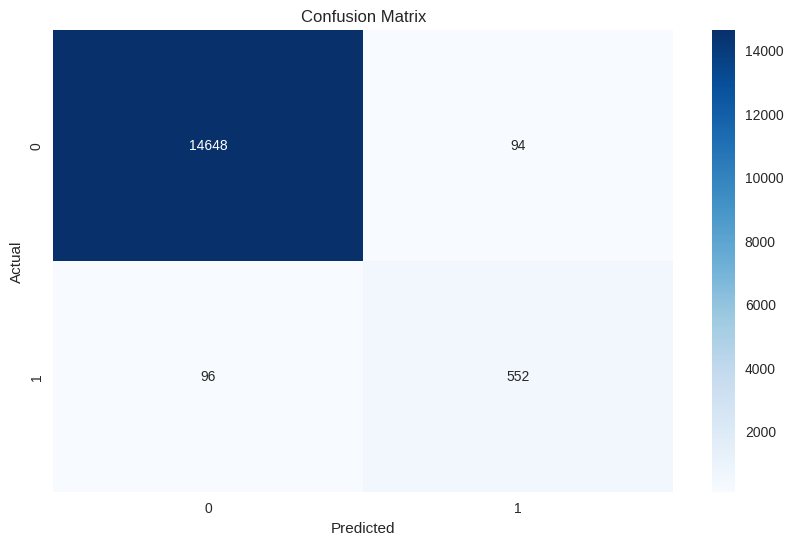

In [22]:
%%time
extra_tree_train(x_train, x_test, y_train, y_test)

roc_auc_score :  0.9222714014380681
accuracy_score:  0.988174139051332
precision_score:  0.8663522012578616
recall_score:  0.8503086419753086
f1-score : 0.8582554517133957
confusion_matrix:  [[14657    85]
 [   97   551]]

confusion_matrix

CPU times: user 2.9 s, sys: 110 ms, total: 3.02 s
Wall time: 2.91 s


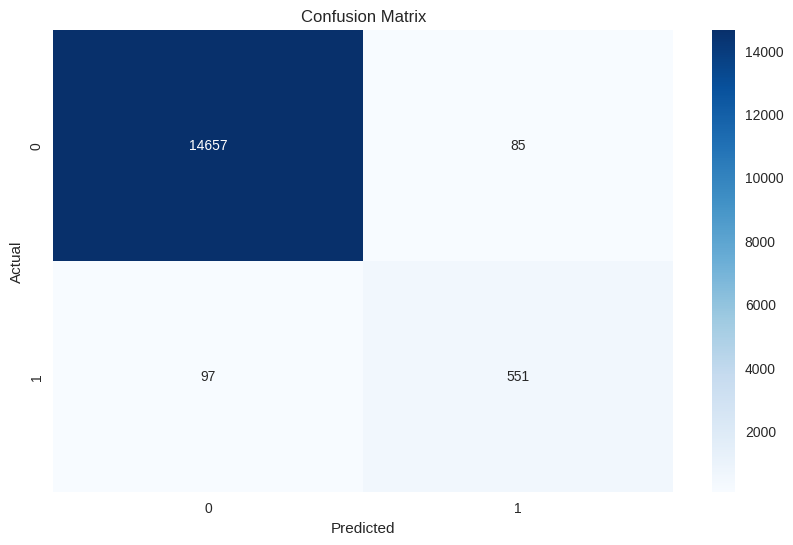

In [23]:
%%time
random_forest_classifier(x_train, x_test, y_train, y_test)

roc_auc_score :  0.9235178401845068
accuracy_score:  0.9891487979207277
precision_score:  0.8860353130016051
recall_score:  0.8518518518518519
f1-score : 0.8686073957513768
confusion_matrix:  [[14671    71]
 [   96   552]]

confusion_matrix

[0.1279301  0.47203737 0.3689408  0.03109166 0.        ]
CPU times: user 3.74 s, sys: 112 ms, total: 3.85 s
Wall time: 2.09 s


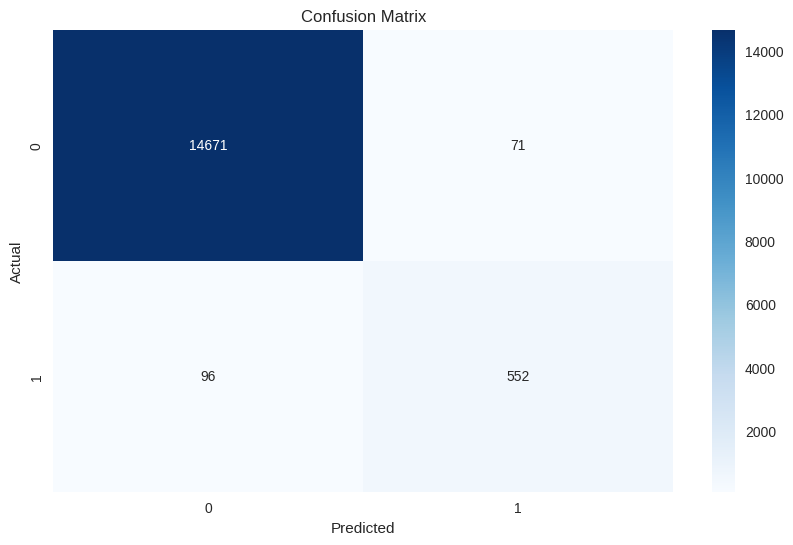

In [56]:
%%time
xgb_model = xgboost_classifier(x_train, x_test, y_train, y_test)

roc_auc_score :  0.750695292361959
accuracy_score:  0.9774528914879792
precision_score:  0.9287749287749287
recall_score:  0.5030864197530864
f1-score : 0.6526526526526526
confusion_matrix:  [[14717    25]
 [  322   326]]

confusion_matrix

CPU times: user 8.74 s, sys: 110 ms, total: 8.85 s
Wall time: 9.49 s


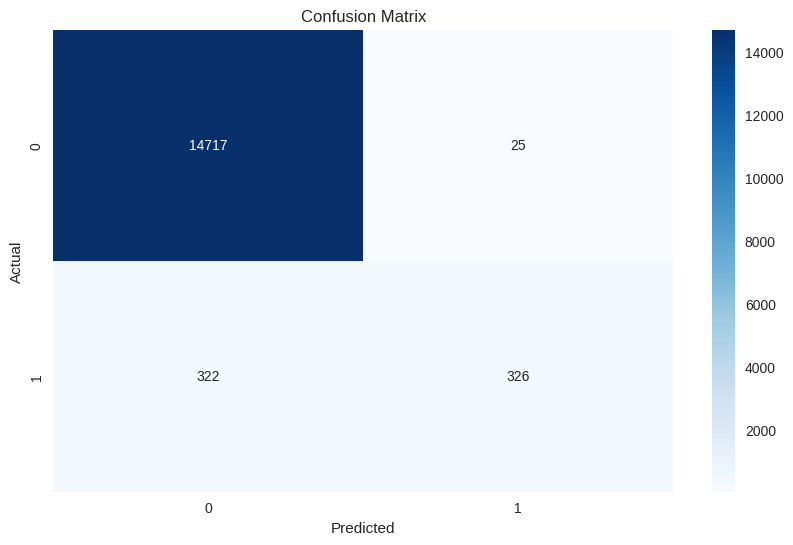

In [26]:
%%time
SVM_classifier(x_train, x_test, y_train, y_test)

# prediction

In [64]:
url = 'https://www.presstv.ir/Detail/2023/04/28/702388/No-trace-toxic-substances-found-schools-Iran-Intelligence-Ministry'
soup = get_html(url)
features = create_page_feature(soup)
features['depth_normalize'] = zscore(features['depth'])

features[features["label"] == 2]["label"] = 0
features['content lengh'] = features['content lengh'].astype(int)
features['depth'] = dataset['depth'].astype(int)
features['title_content_intersection_ratio'] = dataset['title_content_intersection_ratio'].astype(float)
features['depth_normalize'] = features['depth_normalize'].astype(float)
features['words in content'] = features['words in content'].astype(float)
features['label'] = features['label'].astype(bool)
X = features.drop(['label', 'content'],axis=1)
y_pred = xgb_model.predict(X)

In [75]:
main_content_index = [i for i, y in enumerate(y_pred) if y == 1]

In [76]:
main_content_index

[5]

In [80]:
features["content"].iloc[main_content_index[0]]

'The ministry acknowledged that the incidents took place in the midst of violent riots after the death of 22-year-old Mahsa Amini in police custody in Tehran in mid-September.'